Suppose you have a population of wild animals and you want to estimate the population size. It's impractical to catch all of them, so what do you do? A standard method is ['mark and recapture'](https://en.wikipedia.org/wiki/Mark_and_recapture): catch some animals, mark them, release them, and catch some again. In the second capture, there will be some marked animals and some unmarked (i.e., not seen before). The ratio gives you some information about the population size.

The standard estimator for the population size is the [Lincoln index](https://en.wikipedia.org/wiki/Lincoln_index), but it is only applicable in the case of two capture events. What if we want to *repeatedly* capture, mark, and release, and mark the animals such that we know how many times each has been captured? I'm by no means an expert in frequestist statistical methods, so I don't know what the approach would be in this iterated capture case, but I gather it's complicated. What I'll show in this notebook is how to do Bayesian inference for this problem. If you just want to see some code, skip to the bottom of this notebook.


An example of Bayesian inference of population size for iterated mark-and-recapture is shown in the following video.

In [2]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/xzCq-rQ8Omk" frameborder="0" allowfullscreen></iframe>')

The left hand side is a (crude) simulation of animals moving around. During a capture event, a square appears and the animals within are captured. An animal's colour indicates the number of times it has been captured. The right hand side shows the current state of belief about the total population size.

## Assumptions

In the following we'll make these simplifying modelling assumptions:

- The population size is constant. Animals don't leave or join the population between capture events.
- Every animal has an equal probability of being captured, and this probability is independent between capture events.
- The total number of animals captured in a given capture event does *not* depend on the total population size (apart from being upper-bounded by it). This is clearly not true in the animation above, but is often true in mark-and-recapture field work. Note, if this were not true then the number of animals captured at each stage would give us further information about the total population size.

## Short Bayesian Inference Intro/Recap

In Bayesian inference we assign probabilities to hypotheses to represent our state of belief, and use [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update the probability of a hypothesis using the probability of an observation *given* that hypothesis.

Bayes' theorem says that, for any two random variables $H$ and $X$:

$P(H\mid X) \propto P(X \mid H) \cdot P(H)$.

If we let $X$ stand for an observation, and $H$ for a hypothesis, then what this says is: "The **probability that a hypothesis is true after making an observation** (called the *posterior*) is proportional to its **probability before that observation** (called the *prior*) multiplied by **the probability of making that observation if the hypothesis is true** (called the *likelihood*). An important feature of Bayesian inference for our mark-and-recapture problem is that if you make a sequence of observations, you can iteratively apply Bayes' theorem to keep updating your posterior belief.

So, to do Bayesian inference you need to be able to:

1. Specify a prior distribution over hypotheses, in the absence of observational data.
2. For a given hypothesis and observation, compute the likelihood, i.e., the probability of having made that observation.
3. Re-normalize the posterior distribution, so that it sums to 1.

## Our Prior Distribution, and Normalization

The normalization step is often the hard part. In our case, we're going to simplify things by using a prior distribution that assigns non-zero probability to only a finite set of hypotheses. Normalization, then, is just a matter of rescaling the posterior probability vector so that it always sums to 1.

E.g., the above animation uses a prior $p(k) = \frac{1}{350}$ for population size $k$ between 100 and 450, and assigns 0 probability otherwise. I.e., before making observations we believe it to be equally likely that the total population size is any value between 100 and 450.

## The Likelihood

Suppose we've previously made several captures, and there are $10$ animals that have been captured once, $5$ that have been captured twice, and none that have been captured more than twice. We *don't* know how many have been captured zero times, but a hypothesis that there are $k$ animals in total says that there are $k-15$ such animals.

So, rephrasing the hypothesis: "The number of animals that have been captured zero, one, and two times is $k-15$, $10$, and $5$", and if we then capture again (sampling without replacement), the number of the newly captured animals that have previously been captured zero, one, or two times follows a [multivariate hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution#Multivariate_hypergeometric_distribution), so this gives us our likelihood.

(Quick probability distribution recap: suppose you have an urn with $N_1$ white balls and $N_2$ black balls, and you sample $M$ times with replacement. The binomial distribution is the probability distribution over the number of white balls you will observe. If you sample instead **without** replacement, the number of white balls sampled follows a hypergeometric distribution. The multivariate hypergeometric distribution is the generalization to more than two colours of balls, and is the distribution over the vector of counts for each colour that you will observe.)

## Some Code

First we need a way to compute the likelihood of a given observation for a multivariate hypergeometric distribution. Unfortunately, Scipy only implements the univariate case. Fortunately, we can build the multivariate case out of recursive univariate hypergeometric distributions, i.e., by first computing the likelihood of the number of zero vs greater than zero previous captures, then the number of one vs greater than one, etc.

In [1]:
import numpy as np
from scipy.stats import hypergeom

# The two input vectors here are the number of individuals in the population
# and in the latest capture that have been observed 0, 1, 2, etc. times.
# Each of these numbers is known, except for the population number of individuals
# that have been observed zero times. This is determined by our hypotheses.
def multi_hypergeom_likelihood(observation_vector, population_vector):
    obs_head, *obs_tail = observation_vector
    pop_head, *pop_tail = population_vector
    
    if len(obs_tail) == 0:
        return 1.0
    
    return hypergeom.pmf(
        obs_head,
        sum(population_vector),
        pop_head,
        sum(observation_vector)
    ) * multi_hypergeom_likelihood(obs_tail, pop_tail)

Now let's set up a population and a prior belief over its size.

In [22]:
true_population_size = 350

# A uniform prior distribution
candidate_population_sizes = np.arange(100, 450)
belief = np.ones_like(candidate_population_sizes, dtype=np.float32)
belief /= belief.sum()

# This is to keep track of how many times each member of the population has been seen.
# Note that for convenience we also record the counts for individuals that have never been
# captured before. This information is *not* used when computing likelihoods, since it is
# 'unknown' and implied by the hypothesis.
population_capture_counts = np.zeros(true_population_size, dtype=np.int32)

Here we crudely simulate the process of capturing animals.

In [11]:
def capture(true_population_size):
    number_captured = np.random.randint(30, 61)
    
    captured_indices = np.random.choice(
        true_population_size,
        replace=False,
        size=number_captured
    )
    
    return captured_indices

And here is some code for computing the likelihood for each hypothesis and updating the posterior over hypotheses.

In [2]:
def update_belief(candidate_pop_sizes, belief, population_capture_counts, captured_indices):
    max_capture_count = np.max(population_capture_counts)
    captured_prev_capture_counts = population_capture_counts[captured_indices]
    
    # Compute a vector of the number of individuals in the population
    # / latest capture that have been previously observed 0, 1, 2, etc.
    # times. Each of these is a known quantity, except for the
    # number of animals in the population that have previously
    # not been observed. This value will be filled in according to each
    # hypothesis before computing likelihoods.
    observation_vector = [sum(captured_prev_capture_counts == i) for i in range(max_capture_count + 1)]
    true_population_vector = [sum(population_capture_counts == i) for i in range(max_capture_count + 1)]
    
    for k_i, k in enumerate(candidate_pop_sizes):
        hypothesized_pop_vector = np.copy(true_population_vector)
        hypothesized_pop_vector[0] = k - np.sum(true_population_vector[1:])
        
        likelihood = multi_hypergeom_likelihood(observation_vector, hypothesized_pop_vector)
        belief[k_i] *= likelihood

    belief[~np.isfinite(belief)] = 0
    belief /= belief.sum()
    return belief

Now let's simulate eight rounds of capture, mark, and release, and plot the posterior belief over the population size at each step.

Capture event number 1


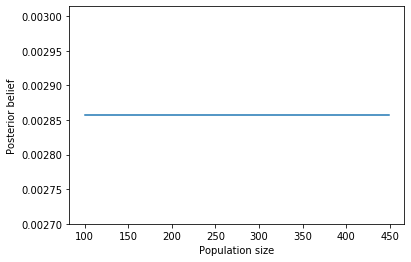

Capture event number 2


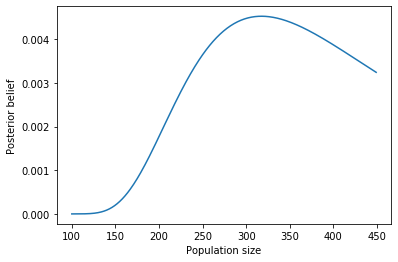

Capture event number 3


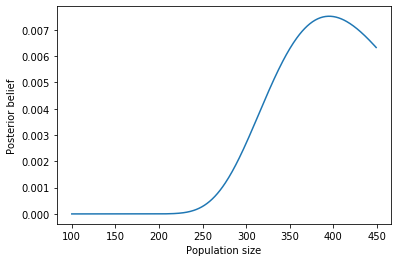

Capture event number 4


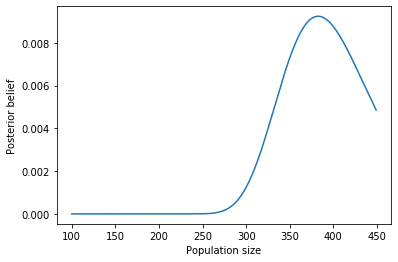

Capture event number 5


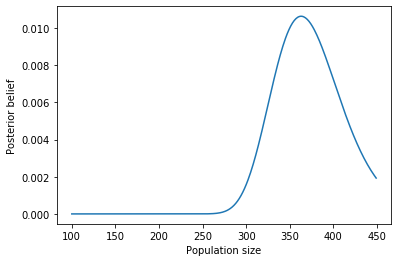

Capture event number 6


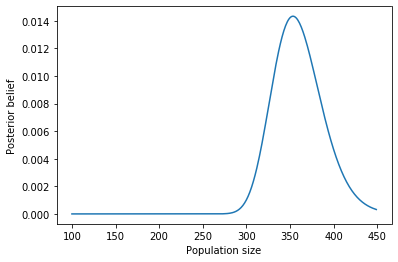

Capture event number 7


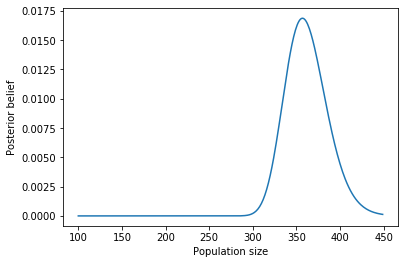

Capture event number 8


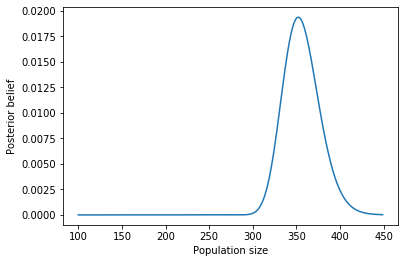

In [23]:
import matplotlib.pyplot as plt

# There will be 5 capture events
for observation_i in range(8):

    # Capture some animals
    captured_idx = capture(true_population_size)

    # Update posterior based on how many times each had been seen before
    belief = update_belief(
        candidate_population_sizes,
        belief,
        population_capture_counts,
        captured_idx
    )

    # Update the population counts
    population_capture_counts[captured_idx] += 1
    
    # Plot the posterior
    print(f'Capture event number {observation_i + 1}')
    plt.plot(candidate_population_sizes, belief)
    plt.xlabel('Population size'); plt.ylabel('Posterior belief'); plt.show()